# Sequential Peptide Retention Time Prediction

### Goal:
* Sequence to value -- Peptide sequence to a time point (0~180 min)
### Background:
* ESDDKPEIEDVGsDEEEEEKK	-- 68.8636
* Peptide is composed of different amino acids (AA)
* Each AA is indicated as a unique letter
### Challenge:
* Every AA introduces a different hydrophobicity <br>
* Different order of the AAs makes them a different integrative hydrophobicity<br>

## 1. Data Processing

### 1.1 General processing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('20231101_BMDM_phospho_PSMs.xlsx')

In [3]:
select_columns = ['Annotated Sequence','Charge','m/z [Da]','MH+ [Da]','RT [min]','|Log Prob|','Byonic Score']
df1= df[select_columns]
# Remove data points with low confidences
df2 = df1[(df1['Byonic Score'] > 500) & (df['|Log Prob|'] > 5)]
df2['Annotated Sequence'] = df1['Annotated Sequence'].str.extract(r'\.(.*?)\.')
feature=['Encoded']
df2['length'] = df2['Annotated Sequence'].apply(len)
df3 = df2[(df2['length'] > 8) & (df2['length'] <= 25)].reset_index(drop=True)
df3.head(3)

/var/folders/0g/1v_dx9s92_d_fs88qdtmgffh0000gn/T/ipykernel_57587/750663411.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Annotated Sequence'] = df1['Annotated Sequence'].str.extract(r'\.(.*?)\.')
/var/folders/0g/1v_dx9s92_d_fs88qdtmgffh0000gn/T/ipykernel_57587/750663411.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['length'] = df2['Annotated Sequence'].apply(len)


,Annotated Sequence,Charge,m/z [Da],MH+ [Da],RT [min],|Log Prob|,Byonic Score,length
0,SPSDYSNFDPEFLNEKPQLsFSDK,3,957.75176,2871.24073,123.1943,31.27,1612.2,24
1,ESDDKPEIEDVGsDEEEEEKK,3,839.34072,2516.00761,68.8636,31.06,1591.8,21
2,ESDDKPEIEDVGsDEEEEEKK,3,839.34135,2516.00949,69.2675,31.06,1552.9,21


### 1.2 One-Hot Encoding

In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

sequences = df3['Annotated Sequence'].values

# Tokenize the sequences
tokenizer = Tokenizer(char_level=True)  # Treat each character as a token
tokenizer.fit_on_texts(sequences)
encoded_sequences = tokenizer.texts_to_sequences(sequences)

# Find the maximum length for padding
max_length = max(len(seq) for seq in encoded_sequences)

# Padding
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_length, padding='post')

#Define the Embedding Layer parameters
vocab_size = len(tokenizer.word_index) + 1 

### 1.3 Positional Encoding

In [46]:
import math

def positional_encoding(max_length, embedding_dim):
    PE = np.zeros((max_length, embedding_dim))
    for pos in range(max_length):
        for i in range(0, embedding_dim, 2):
            PE[pos, i] = math.sin(pos / (10000 ** ((2 * i) / embedding_dim)))
            PE[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i) / embedding_dim)))
    return PE

pos_enc = positional_encoding(max_length, embedding_dim)

### 1.4 Train Test Split

In [103]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert padded sequences and retention times to PyTorch tensors
X = torch.tensor(padded_sequences, dtype=torch.long)  # Long type for embeddings
y = torch.tensor(df3['RT [min]'].values, dtype=torch.float32).unsqueeze(1)

# Splitting the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=20)

batch_size = 64

all_data = TensorDataset(X, y)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

print(X_train.shape)

torch.Size([18711, 25])


## 2. Model Buildup and Model Evaluation

### 2.1 Neuron Network with LSTM layer

In [109]:
import torch.optim as optim
embedding_dim = 30

class PeptideLSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(PeptideLSTMNet, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.pos_encoding = positional_encoding(max_length, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=64, batch_first=True)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64, 32)
        self.dropout1 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 8)
        self.out = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        
        pos_enc_tensor = torch.tensor(self.pos_encoding, dtype=torch.float32).to(x.device)
        x = x + pos_enc_tensor[:x.size(1), :].unsqueeze(0)
        
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Using the output of the last LSTM cell
        x = self.bn1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.bn2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.bn3(x)
        x = torch.relu(self.fc3(x))
        x = self.out(x)
        return x

model = PeptideLSTMNet(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())


### 2.2 Four Layers -- Overfitting Model for Small-size Data

In [108]:
import torch.optim as optim
embedding_dim = 30
class PeptideLSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(PeptideLSTMNet, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.pos_encoding = positional_encoding(max_length, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=256, batch_first=True)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 24)
        self.dropout3 = nn.Dropout(0.5)
        self.bn4 = nn.BatchNorm1d(24)
        self.fc4 = nn.Linear(24, 12)
        self.out = nn.Linear(12, 1)

    def forward(self, x):
        x = self.embedding(x)
        
        pos_enc_tensor = torch.tensor(self.pos_encoding, dtype=torch.float32).to(x.device)
        x = x + pos_enc_tensor[:x.size(1), :].unsqueeze(0)
        
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Using the output of the last LSTM cell
        x = self.bn1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.bn2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.bn3(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.bn4(x)
        x = torch.relu(self.fc4(x))
        x = self.out(x)
        return x

model = PeptideLSTMNet(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())


### 2.3 Training with Cross-Validation

In [110]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

# Use small data for hyperparameter tuning
# dataset_size = len(test_data)
dataset_size = len(train_data)

indices = list(range(dataset_size))
history = []
# Training loop function with cross-validation
def train_model_with_cv(model, dataset, criterion, optimizer, epochs=50):
    for fold, (train_indices, val_indices) in enumerate(kfold.split(indices)):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        fold_history = []
        for epoch in range(epochs+1):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            if epoch % 20 == 0:
                model.eval()
                #with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)
                print('Fold {}, Epoch {}, Training Loss {}, Validation Loss {}'.format(fold+1, epoch, loss.item(), val_loss.item()))
            else:
                print('Fold {}, Epoch {}, Training Loss {}'.format(fold+1, epoch, loss.item()))
            fold_history.append(loss.item())
        history.append(fold_history)

# Testing
#train_model_with_cv(model, test_data, criterion, optimizer)
train_model_with_cv(model, train_data, criterion, optimizer)

Fold 1, Epoch 0, Training Loss 4345.9150390625, Validation Loss 3829.972900390625
Fold 1, Epoch 1, Training Loss 783.1192626953125
Fold 1, Epoch 2, Training Loss 492.0649719238281
Fold 1, Epoch 3, Training Loss 348.28961181640625
Fold 1, Epoch 4, Training Loss 475.80987548828125
Fold 1, Epoch 5, Training Loss 263.10418701171875
Fold 1, Epoch 6, Training Loss 191.9562225341797
Fold 1, Epoch 7, Training Loss 164.24026489257812
Fold 1, Epoch 8, Training Loss 319.86810302734375
Fold 1, Epoch 9, Training Loss 180.9126739501953
Fold 1, Epoch 10, Training Loss 219.7364501953125
Fold 1, Epoch 11, Training Loss 102.09355926513672
Fold 1, Epoch 12, Training Loss 121.20842742919922
Fold 1, Epoch 13, Training Loss 123.66524505615234
Fold 1, Epoch 14, Training Loss 83.43072509765625
Fold 1, Epoch 15, Training Loss 159.94760131835938
Fold 1, Epoch 16, Training Loss 113.68753814697266
Fold 1, Epoch 17, Training Loss 171.49937438964844
Fold 1, Epoch 18, Training Loss 192.19642639160156
Fold 1, Epoch 1

In [97]:
import matplotlib.pyplot as plt
import statistics

88.81873321533203


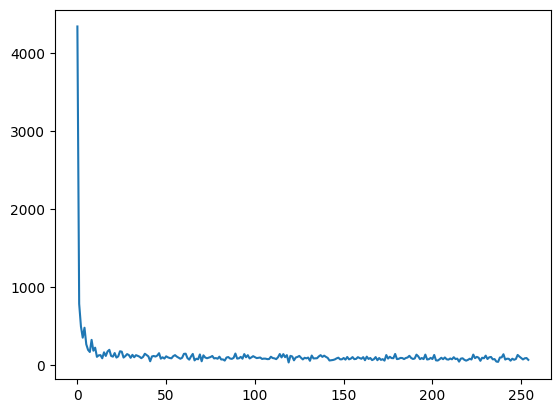

In [112]:
graph = []
for i in history:
    graph += i
print(statistics.median(graph))
plt.plot(graph)

## 3. Prediction and Other Features

### 3.1 Prediction of the Test Data

In [111]:
def predict_and_evaluate_accuracy(model, test_loader, tolerance=10.0):
    model.eval()
    predictions = []
    actual_values = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.tolist())
            actual_values.extend(labels.squeeze().tolist())

            # Calculate accuracy within the tolerance range
            correct_predictions += torch.sum(torch.abs(outputs - labels.squeeze()) <= tolerance)
            total_predictions += labels.size(0)

    accuracy = correct_predictions.float() / total_predictions * 100

    return predictions, actual_values, accuracy.item()

predictions, actual_values, test_accuracy = predict_and_evaluate_accuracy(model, test_loader)
print(f'Test Accuracy with ±10 Tolerance: {test_accuracy:.2f}%')

print("Predictions:", predictions[0:5])
print("Actual Values:", actual_values[0:5])


Test Accuracy with ±10 Tolerance: 86.54%
Predictions: [63.663490295410156, 90.498291015625, 90.08969116210938, 87.46794891357422, 84.13177490234375]
Actual Values: [64.45800018310547, 91.08429718017578, 112.83689880371094, 86.18910217285156, 80.87129974365234]


### 3.2 Get Weight Information

In [60]:
for param in model.parameters():
    print(param.data)

tensor([[-4.2847e-01,  5.6858e-02, -4.5014e-01,  1.1169e+00, -2.3414e-01,
         -1.0606e-01, -6.2777e-01, -3.6077e-01,  3.1041e-01,  3.7937e-01,
          2.3753e-01,  1.2335e-01, -1.3020e-01,  9.8012e-02, -3.8509e-01,
          4.0290e-02,  1.2544e-01, -2.7296e-01, -1.8250e-01,  1.2843e-01,
          2.0874e-02, -1.2376e+00, -8.4315e-02,  5.0702e-02,  1.2950e-01,
         -7.7868e-01, -2.0103e-01,  2.2111e-02,  1.5930e-01, -4.6583e-01],
        [ 1.5314e+00,  3.0779e-01,  2.2975e-01, -8.0506e-01,  3.8078e-01,
         -5.6286e-01, -1.8248e-01, -1.1479e+00,  2.0571e+00, -7.6001e-01,
          2.4097e-02,  8.8095e-01, -2.0717e-01,  4.6575e-02, -8.9609e-01,
          9.2091e-01, -9.2830e-01,  1.8499e-01, -2.5250e-01,  9.0252e-02,
         -7.4355e-01, -1.7183e+00,  6.3870e-01, -2.9789e-01, -5.7779e-01,
          6.4089e-01, -1.0215e+00, -2.0707e-01,  1.1305e+00, -1.7774e-01],
        [ 3.1969e-01,  6.4029e-01, -2.1453e-01,  4.0081e-01, -3.4573e-01,
          2.2901e-01,  3.1045e-01,  

## 4. Conclusion

* Our model has a average loss of 70, pretty comparable to the published literature value (loss: 33~133)
* Tolerance +- 10 is sufficient enough for the application of setting the dynamic window for a targeted peptide on the instrument (mass spectrometry)